# Calculate Nino indices

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [4]:
# Read SST data
f = 'data/era5_monthly_sst_5x5.nc'
sst = xr.open_dataarray(f)
sst

<xarray.DataArray 'sst' (time: 1008, lat: 13, lon: 72)> Size: 4MB
[943488 values with dtype=float32]
Coordinates:
  * lon      (lon) float32 288B 0.0 5.0 10.0 15.0 ... 340.0 345.0 350.0 355.0
  * lat      (lat) float32 52B -30.0 -25.0 -20.0 -15.0 ... 15.0 20.0 25.0 30.0
  * time     (time) datetime64[ns] 8kB 1940-01-01 1940-02-01 ... 2023-12-01
Attributes:
    units:      K
    long_name:  Sea surface temperature

In [20]:
# Calculate monthly anomaly
clm = sst.groupby('time.month').mean()
ssta = sst.groupby('time.month') - clm
ssta = ssta.drop_vars('month')

In [21]:
def nino_indices(da):
    """
    Parameters
    ----------
    da : xarray.DataArray (lat, lon, )
        SST anomaly data
    
    Returns
    -------
    nino : xarray.Dataset
        Nino indices
    """
    # Grid area weight
    wgt = np.cos(np.deg2rad(da.lat))
    
    nino3 = da.sel(lon=slice(210, 270), lat=slice(-5, 5)
                   ).weighted(wgt).mean(dim=['lat', 'lon']).assign_attrs(
            {'long_name': 'Niño 3', 'units': '°C'}
            ).rename('nino3')
    nino4 = da.sel(lon=slice(160, 210), lat=slice(-5, 5)
                   ).weighted(wgt).mean(dim=['lat', 'lon']).assign_attrs(
            {'long_name': 'Niño 4', 'units': '°C'}
            ).rename('nino4')
    nino34 = da.sel(lon=slice(190, 240), lat=slice(-5, 5)
                    ).weighted(wgt).mean(dim=['lat', 'lon']).assign_attrs(
            {'long_name': 'Niño 3.4', 'units': '°C'}
            ).rename('nino34')
    
    oni = nino34.rolling(time=3, center=True).mean().assign_attrs(
        {'long_name': 'ONI', 'units': '°C'}
        ).rename('oni')

    nino = xr.merge([nino3, nino4, nino34, oni]).compute()

    return nino

In [22]:
nino = nino_indices(ssta)

In [26]:
# Save to csv
outf = 'data/era5_nino.csv'
nino.to_dataframe().to_csv(outf)

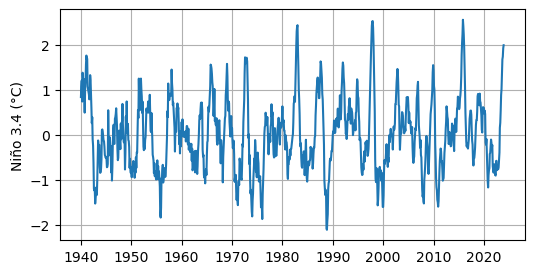

In [23]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(nino.time, nino['nino34'])
ax.set(
    ylabel='Niño 3.4 (°C)',
)
ax.grid()